# IMC-Denoise: a content aware denoising pipeline to enhance imaging mass cytometry

Here we will show an example for CD38 channel denoising using our own human bone marrow IMC dataset. First, import all the essential libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tp
from IMC_Denoise.IMC_Denoise_main.DIMR import DIMR
from IMC_Denoise.IMC_Denoise_main.DeepSNF import DeepSNF
from IMC_Denoise.DataGenerator.DeepSNF_DataGenerator import DeepSNF_DataGenerator

Using TensorFlow backend.


### Training data preparation
Next, we use our raw images to build a training set.
Note: 
1. The marker name must be consistant with the corresponding marker name in image file names.
2. Raw_directory is the folder of all the raw images used for generating training set. Its subfolders are the imagesets of different tissues. The subfolders contains all the marker images of the same tissue. 
### Data_structure example:
<b><br>|---Raw_image_directory
<br>|---|---Tissue1
<br>|---|---|---Marker1_img.tiff
<br>|---|---|---Marker2_img.tiff
<br>             ...
<br>|---|---|---Marker_n_img.tiff
<br>|---|---Tissue2
<br>|---|---|---Marker1_img.tiff
<br>|---|---|---Marker2_img.tiff
<br>             ...
<br>|---|---|---Marker_n_img.tiff
<br>             ...
<br>|---|---Tissue_m
<br>|---|---|---Marker1_img.tiff
<br>|---|---|---Marker2_img.tiff
<br>             ...
<br>|---|---|---Marker_n_img.tiff
</b>
3. n_neighbour and n_lambda are the parameters from DIMR algorithm for hot pixel removal in the training set generation process. 4 and 5 are their defaults. If the defaults are changed, the corresponding parameter should be declared in DeepSNF_DataGenerator(). Otherwise, they can be omitted.
4. The DeepSNF_DataGenerator class search all the CD38 images in raw image directory, split them into multiple 64x64 patches, and then augment the generated data. Note the very sparse patches are removed in this process.

In [2]:
# Release memory
if 'generated_patches' in globals():
    del generated_patches

marker_name = "CD38"
Raw_directory = "D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training"

n_neighbours = 4 # Larger n enables removing more consecutive hot pixels. 
n_lambda = 5 # Smaller n enables removing more hot pixels but may also generate false negatives. 
window_size = 3 # Slide window size. For IMC images, window_size = 3 is fine.

DataGenerator = DeepSNF_DataGenerator(marker_name = marker_name, n_neighbours = n_neighbours, n_lambda = n_lambda)
generated_patches = DataGenerator.generate_patches_from_directory(load_directory = Raw_directory)
print('The shape of the generated training set is ' + str(generated_patches.shape) + '.')

Image data loaded from ...

D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue1\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue10\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue2\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue3\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue4\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue5\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue6\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue7\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue8\141Pr-CD38_Pr141.tiff
D:\python_file_folder\IMC_learning\IMC_Denoise\Raw_IMC_for_training\Tissue9\141Pr-CD38_Pr

### Show several generated patches of the training set: Anscombe transformed

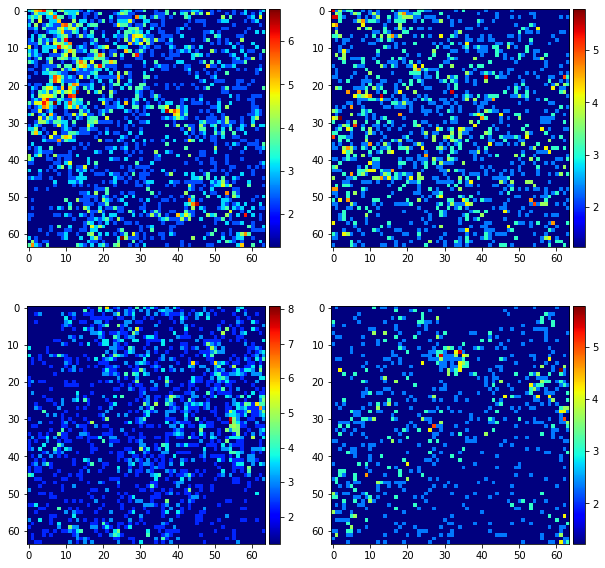

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(generated_patches[0,:,:], cmap = 'jet')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(generated_patches[100,:,:], cmap = 'jet')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(generated_patches[1000,:,:], cmap = 'jet')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(generated_patches[-1,:,:], cmap = 'jet')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')

### DeepSNF configuration and training
Define parameters for DeepSNF training.

In [4]:
train_epoches = 30 # training epoches, which should be at least 100 for a good training result. The default is 100.
train_initial_lr = 5e-4 # inital learning rate. The default is 5e-4.
train_batch_size = 256 # training batch size. For a GPU with smaller memory, it can be tuned smaller. The default is 256.
pixel_mask_percent = 0.2 # percentage of the masked pixels in each patch. The default is 0.2.
val_set_percent = 0.15 # percentage of validation set. The default is 0.15.
loss_function = "bce" # loss function used. The default is "bce".
weights_name = None # trained network weights saved here. If None, the weights will not be saved.
loss_name = None # training and validation losses saved here, either .mat or .npz format. If not defined, the losses will not be saved.
weights_save_directory = None # location where 'weights_name' and 
# 'loss_name' saved. If the value is None, the files will be saved in the current file folder.
is_load_weights = False # Use the trained model directly. Will not read from saved one.
deepsnf = DeepSNF(train_epoches = train_epoches, 
                  train_learning_rate = train_initial_lr,
                  train_batch_size = train_batch_size,
                  mask_perc_pix = pixel_mask_percent,
                  val_perc = val_set_percent,
                  loss_func = loss_function,
                  weights_name = weights_name,
                  loss_name = loss_name,
                  weights_dir = weights_save_directory, 
                  is_load_weights = is_load_weights)

### Start training
If errors happen, check if the GPUs are being used by other sessions. If yes, shutdown the session occupying GPUs and re-run the prediction

In [5]:
train_loss, val_loss = deepsnf.train(generated_patches)

The range value to the corresponding model is 14.234071752296156.
Input Channel Shape => (19896, 64, 64, 1)
Number of Training Examples: 16911
Number of Validation Examples: 2985
Each training patch with shape of (64, 64) will mask 8 pixels.
Training model...
Epoch 1/30
67/67 [==============================] - 68s 1s/step - loss: 0.4068 - val_loss: 0.2383
Epoch 2/30
67/67 [==============================] - 48s 722ms/step - loss: 0.2408 - val_loss: 0.2318
Epoch 3/30
67/67 [==============================] - 48s 723ms/step - loss: 0.1795 - val_loss: 0.1761
Epoch 4/30
67/67 [==============================] - 49s 725ms/step - loss: 0.1587 - val_loss: 0.1627
Epoch 5/30
67/67 [==============================] - 49s 725ms/step - loss: 0.1497 - val_loss: 0.1576
Epoch 6/30
67/67 [==============================] - 49s 726ms/step - loss: 0.1461 - val_loss: 0.1547
Epoch 7/30
67/67 [==============================] - 49s 726ms/step - loss: 0.1448 - val_loss: 0.1507
Epoch 8/30
67/67 [==================

### Plot the training and validation losses

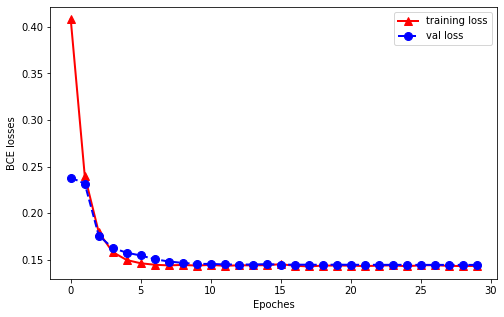

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(np.array(range(len(train_loss))),train_loss, color='red', marker='^', linewidth=2, markersize=8)
plt.plot(np.array(range(len(val_loss))),val_loss, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Epoches')
plt.ylabel('BCE losses')
plt.legend(['training loss', 'val loss'])
plt.show()

### Load a raw CD38 image

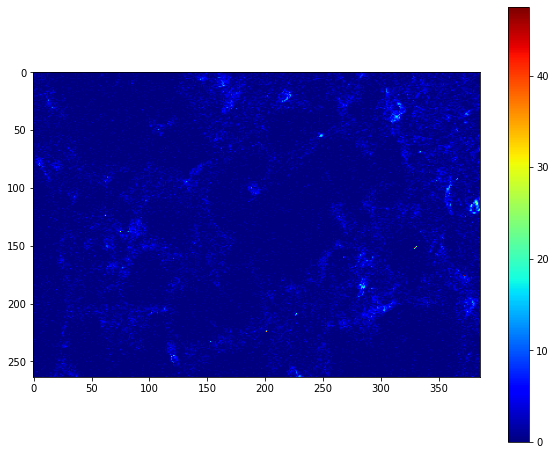

In [7]:
# read a CD38 raw image.
Raw_img_name = 'D:\IMC analysis\Raw_IMC_dataset\F_r2\\141Pr-CD38_Pr141.tiff' # change to your raw image
Img_raw = tp.imread(Raw_img_name)
plt.figure(figsize = (10,8))
plt.imshow(Img_raw, vmin = 0, vmax = 0.5*np.max(Img_raw), cmap = 'jet')
plt.colorbar()
plt.show()

### Perform the DIMR algorithm only if the SNR of the raw image is high.

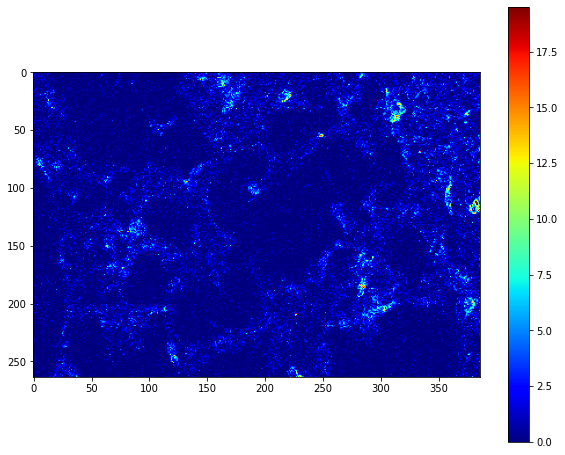

In [8]:
Img_DIMR = DIMR(n_neighbours = n_neighbours, n_lambda = n_lambda, window_size = window_size).perform_DIMR(Img_raw)
plt.figure(figsize = (10,8))
plt.imshow(Img_DIMR, vmin = 0, vmax = 0.5*np.max(Img_DIMR), cmap = 'jet')
plt.colorbar()
plt.show()

### If the SNR of the raw image is sub-optimal, perform DIMR and DeepSNF algorithms for low SNR raw images.

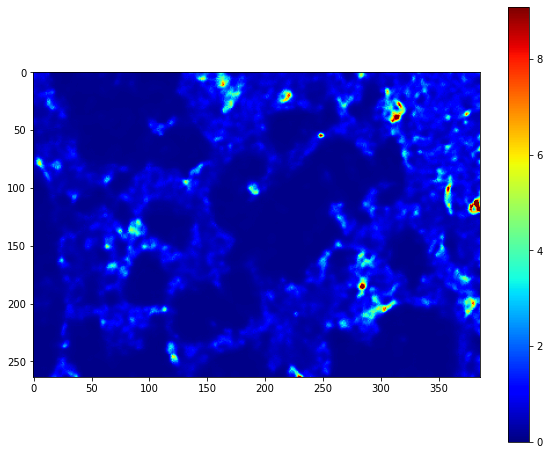

In [9]:
# perform DIMR and DeepSNF algorithms for low SNR raw images.
Img_DIMR_DeepSNF = deepsnf.perform_IMC_Denoise(Img_raw, n_neighbours = n_neighbours, n_lambda = n_lambda, window_size = window_size)
plt.figure(figsize = (10,8))
plt.imshow(Img_DIMR_DeepSNF, vmin = 0, vmax = 0.5*np.max(Img_DIMR_DeepSNF), cmap = 'jet')
plt.colorbar()
plt.show()